In [2]:
# -*- coding: utf-8 -*-
import os
import sys
import pandas as pd
import numpy as np
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.metrics import log_loss, roc_auc_score, mean_squared_error, accuracy_score, f1_score

import matplotlib.pyplot as plt

import lightgbm as lgb
from lightgbm import log_evaluation, early_stopping



sys.path.append("/Users/wzq/Desktop/game")
# from deepctr_torch.inputs import get_feature_names
# from deepctr_torch.models import *
# from deepctr_torch.callbacks import EarlyStopping

from utils import *
from utils import get_feature_importance_pair


# jupyter配置
from IPython.display import display
pd.options.display.max_rows=10000 #Notebook 的一个cell的显示行数
pd.options.display.max_columns=100000#Notebook 的一个cell的显示列数
pd.set_option('display.max_colwidth', None)

## 训练

In [3]:
data = pd.read_csv('./data/data_processed_v6_1.csv')
print(data.shape)
for f in range(len(data.columns)):
    print(data.columns[f], end=",")
    if f % 20 == 0:
        print()

features = [f for f in data.columns if f not in ["id", "isDefault", "earliesCreditLine", "policyCode", "issueDate"]]
train_size = 800000
target = data.iloc[:train_size, :]['isDefault']
data = data[features]
train_data = data.iloc[:train_size, :]
test_data = data.iloc[train_size:, :]

display(train_data.shape)
display(train_data.head(10))
# display(test_data.shape)
# display(test_data.head(10))
# display(target.shape)
# display(target.head(10))

(1000000, 49)
loanAmnt,
term,interestRate,installment,grade,subGrade,employmentTitle,employmentLength,homeOwnership,annualIncome,verificationStatus,isDefault,purpose,postCode,regionCode,dti,delinquency_2years,ficoRangeLow,ficoRangeHigh,openAcc,pubRec,
pubRecBankruptcies,revolBal,revolUtil,totalAcc,initialListStatus,applicationType,title,n0,n1,n2,n3,n4,n5,n6,n7,n8,n9,n10,n11,n12,
n13,n14,issueDate_year,issueDate_month,issueDate_weekday,issueDate_is_weekend,earliesCreditLine_year,earliesCreditLine_month,

(800000, 48)

,loanAmnt,term,interestRate,installment,grade,subGrade,employmentTitle,employmentLength,homeOwnership,annualIncome,verificationStatus,purpose,postCode,regionCode,dti,delinquency_2years,ficoRangeLow,ficoRangeHigh,openAcc,pubRec,pubRecBankruptcies,revolBal,revolUtil,totalAcc,initialListStatus,applicationType,title,n0,n1,n2,n3,n4,n5,n6,n7,n8,n9,n10,n11,n12,n13,n14,issueDate_year,issueDate_month,issueDate_weekday,issueDate_is_weekend,earliesCreditLine_year,earliesCreditLine_month
0,35000.0,5,19.52,917.97,4,21,292,2.0,2,110000.0,2,1,137,32,17.05,0.0,730.0,734.0,7.0,0.0,0.0,24178.0,48.9,27.0,0,0,1,0.0,2.0,2.0,2.0,4.0,9.0,8.0,4.0,12.0,2.0,7.0,0.0,0.0,0.0,2.0,2014,7,1,0,2001,8
1,18000.0,5,18.49,461.90,3,16,149667,5.0,0,46000.0,2,0,156,18,27.83,0.0,700.0,704.0,13.0,0.0,0.0,15096.0,38.9,18.0,1,0,1394,0.0,3.0,5.0,5.0,10.0,7.0,7.0,7.0,13.0,5.0,13.0,0.0,0.0,0.0,2.0,2012,8,2,0,2002,5
2,12000.0,5,16.99,298.17,3,17,25137,8.0,0,74000.0,2,0,337,14,22.77,0.0,675.0,679.0,11.0,0.0,0.0,4606.0,51.8,27.0,0,0,0,0.0,0.0,3.0,3.0,0.0,0.0,21.0,4.0,5.0,3.0,11.0,0.0,0.0,0.0,4.0,2015,10,3,0,2006,5
3,11000.0,3,7.26,340.96,0,3,36207,10.0,1,118000.0,1,4,148,11,17.21,0.0,685.0,689.0,9.0,0.0,0.0,9948.0,52.6,28.0,1,0,4,6.0,4.0,6.0,6.0,4.0,16.0,4.0,7.0,21.0,6.0,9.0,0.0,0.0,0.0,1.0,2015,8,5,1,1999,5
4,3000.0,3,12.99,101.07,2,11,48,6.0,1,29000.0,2,10,301,21,32.16,0.0,690.0,694.0,12.0,0.0,0.0,2942.0,32.0,27.0,0,0,11,1.0,2.0,7.0,7.0,2.0,4.0,9.0,10.0,15.0,7.0,12.0,0.0,0.0,0.0,4.0,2016,3,1,0,1977,8
5,11000.0,3,7.99,344.65,0,4,39682,7.0,0,39000.0,2,9,512,21,17.14,0.0,730.0,734.0,19.0,0.0,0.0,4047.0,31.1,52.0,1,0,10,12.0,1.0,2.0,2.0,1.0,1.0,48.0,2.0,3.0,2.0,19.0,0.0,0.0,0.0,0.0,2017,4,5,1,1998,7
6,2050.0,3,7.69,63.95,0,3,125101,9.0,0,35000.0,0,0,517,14,17.49,0.0,755.0,759.0,12.0,0.0,0.0,3111.0,8.5,23.0,0,0,0,0.0,1.0,3.0,3.0,7.0,11.0,3.0,10.0,18.0,3.0,12.0,0.0,0.0,0.0,3.0,2014,10,2,0,2006,10
7,11500.0,3,14.98,398.54,2,12,146007,1.0,1,30000.0,2,0,100,4,32.60,0.0,665.0,669.0,8.0,1.0,1.0,14021.0,59.7,33.0,1,0,0,0.0,4.0,4.0,4.0,4.0,16.0,10.0,5.0,21.0,4.0,8.0,0.0,0.0,0.0,2.0,2014,1,2,0,1994,12
8,12000.0,3,12.99,404.27,2,11,176,5.0,2,60000.0,1,0,792,13,19.22,0.0,690.0,694.0,15.0,0.0,0.0,27176.0,46.0,21.0,1,0,0,0.0,7.0,13.0,13.0,7.0,7.0,2.0,13.0,17.0,11.0,15.0,0.0,0.0,0.0,6.0,2016,5,6,1,1994,4
9,6500.0,3,10.99,212.78,1,8,48,6.0,1,15300.0,2,0,59,11,24.39,0.0,725.0,729.0,7.0,0.0,0.0,2936.0,30.6,63.0,0,0,0,0.0,4.0,5.0,5.0,4.0,21.0,24.0,6.0,39.0,5.0,7.0,0.0,0.0,0.0,8.0,2015,11,6,1,1993,1


************************************ 1 ************************************
Training until validation scores don't improve for 50 rounds
[20]	training's auc: 0.728454	valid_1's auc: 0.723581
[40]	training's auc: 0.738827	valid_1's auc: 0.728866
[60]	training's auc: 0.747222	valid_1's auc: 0.732523
[80]	training's auc: 0.753899	valid_1's auc: 0.73435
[100]	training's auc: 0.75931	valid_1's auc: 0.735099
[120]	training's auc: 0.763967	valid_1's auc: 0.735251
[140]	training's auc: 0.76815	valid_1's auc: 0.735453
[160]	training's auc: 0.772086	valid_1's auc: 0.735468
[180]	training's auc: 0.775915	valid_1's auc: 0.735506
Early stopping, best iteration is:
[147]	training's auc: 0.769603	valid_1's auc: 0.735622
[0.7356222948395448]
************************************ 2 ************************************
Training until validation scores don't improve for 50 rounds
[20]	training's auc: 0.729522	valid_1's auc: 0.718901
[40]	training's auc: 0.739912	valid_1's auc: 0.724805
[60]	training's auc

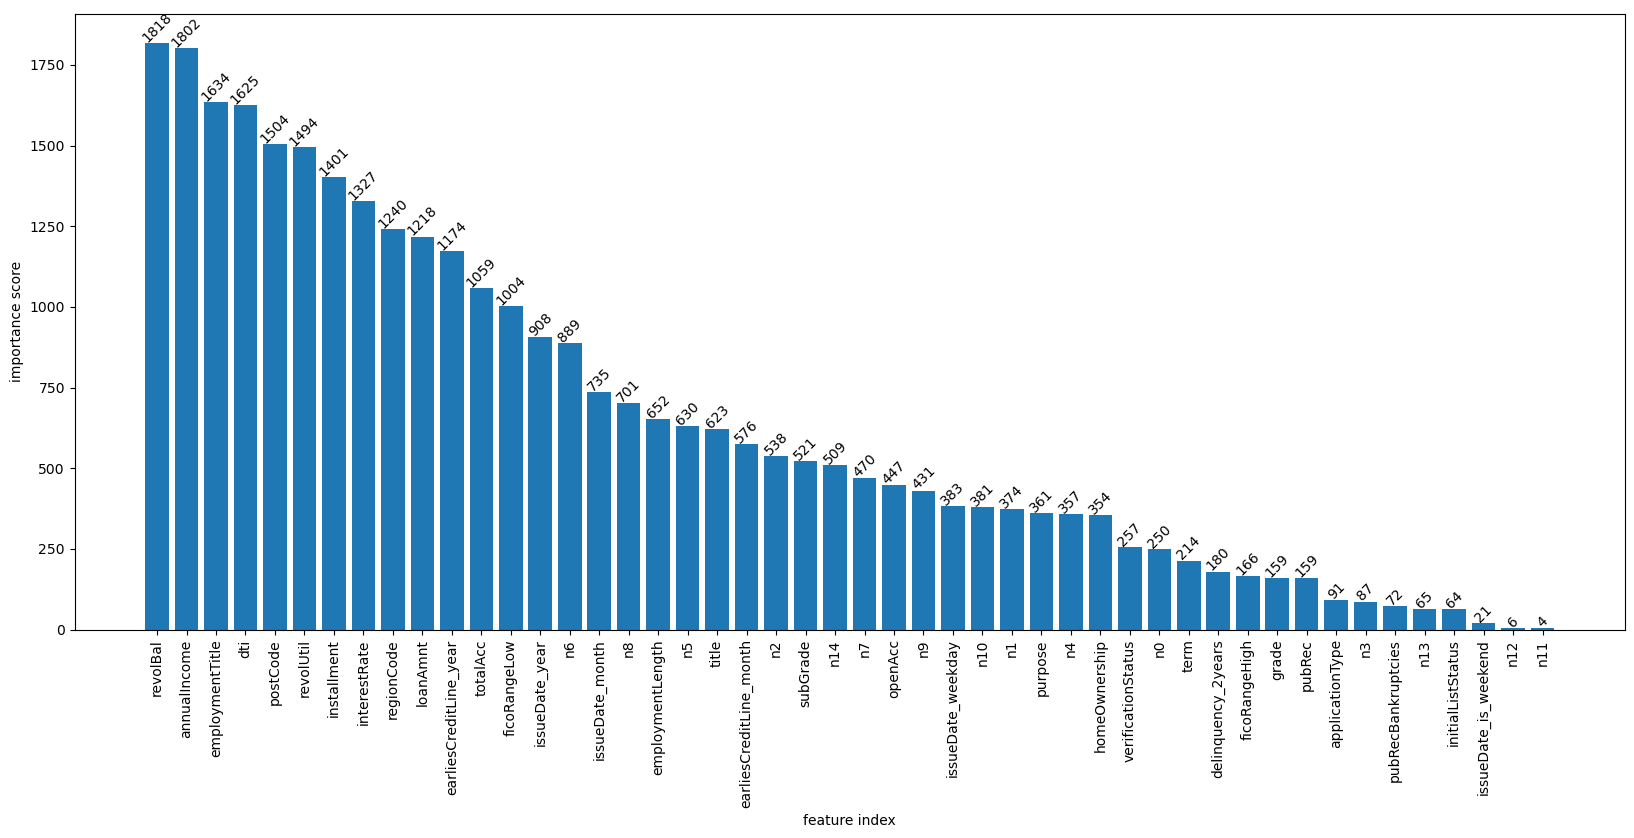

In [4]:
from utils import cv_model

lgb_train, lgb_test, model = cv_model(lgb, train_data, target, test_data, "lgb", is_mms=False)
# xgb_train, xgb_test = xgb_model(train_data, target, test_data)
# cat_train, cat_test = cat_model(train_data, target, test_data)

feature_importance_pair, feature_importance_top = get_feature_importance_pair(model)


In [5]:
sample_result = pd.read_csv("./data/sample_submit.csv")
sample_result["isDefault"] = lgb_test
sample_result.to_csv("./data/sample_result_lgb_feat_v6_1_1.csv", index=False)

## 随机搜惨

In [ ]:
# 随机搜惨
# 设置参数范围
param_dist = {
    'boosting_type': ['gbdt', 'dart'],  # 提升类型  梯度提升决策树（gbdt）和Dropouts meet Multiple Additive Regression Trees（dart）
    'objective': ['binary'],  # 目标；二分类和多分类
    'num_leaves': range(20, 150),  # 叶子节点数量
    'learning_rate': [0.01, 0.05, 0.1],  # 学习率
    'feature_fraction': [0.6, 0.8, 1.0],  # 特征采样比例
    'bagging_fraction': [0.6, 0.8, 1.0],  # 数据采样比例
    'bagging_freq': range(0, 80),  # 数据采样频率
    'verbose': [-1]  # 是否显示训练过程中的详细信息，-1表示不显示
}

# 初始化模型
model = lgb.LGBMClassifier()


# 使用随机搜索进行参数调优
random_search = RandomizedSearchCV(estimator=model,
                                   param_distributions=param_dist, # 参数组合
                                   n_iter=100, 
                                   cv=5, # 5折交叉验证
                                   verbose=2, 
                                   random_state=42, 
                                   n_jobs=-1)
# 模型训练
random_search.fit(train_data, target)

# 输出最佳参数
print("Best parameters found: ", random_search.best_params_)

In [27]:
# sample_result = pd.read_csv("./data/sample_submit.csv")
# sample_result["isDefault"] = lgb_test
# sample_result.to_csv("./data/sample_result_lgb_feat_v4.csv", index=False)

## 模型融合

In [134]:
## 加权融合
lgb_result = pd.read_csv("./data/sample_result_lgb.csv")
lgb_v2_result = pd.read_csv("./data/sample_result_lgb_v2.csv")
xgb_result = pd.read_csv("./data/sample_result_xgb.csv")
cat_result = pd.read_csv("./data/sample_result_cat.csv")

lgb_result["isDefault"] = (lgb_result["isDefault"] + lgb_v2_result["isDefault"] \
                        + xgb_result["isDefault"] + cat_result["isDefault"]) / 4
lgb_result.to_csv("./data/sample_result_ensemble.csv")